In [1]:
import os
import numpy as np
import glob
import pandas as pd
import geopandas as gpd
from argparse import Namespace
import matplotlib.pyplot as plt

from maskrcnn.postprocess.resample import Resampler

In [2]:
# AOI index data w/ georeferencing info
AOI_IN_DIR = 'data/Experiment4/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment4/aoi_download_log.csv'

# satellite derived data
SAT_IN_ANN_DIR = 'data/Siaya2/Pred/infer/'
SAT_IN_IMG_DIR = 'data/Siaya2/Image/'
SAT_IN_GEOM_DIR = 'data/Experiment4/sat.geojson'

## Plotting Images and Annotations

In [ ]:
# read image index data frame
df = pd.merge(pd.read_csv(AOI_IN_DIR),
              pd.read_csv(LOG_IN_DIR).loc[:, 'index'],
              how='right', on='index')

In [ ]:
# set up visualization cfg
cfg = Namespace()
cfg.visual_score_cutoff = 0.5
cfg.xmax = 480
cfg.ymax = 770
cfg.up_scale = 1
cfg.font = 'maskrcnn/utils/fonts/UbuntuMono-B.ttf'
cfg.font_size = 40
cfg.bbox_outline = [255, 255, 255, 255]  # white
cfg.bbox_width = 6  # in pixels
cfg.label_fill = [255, 255, 255, 255]
cfg.category_palette = {
    1: [150, 223, 228, 64],  # blue
    2: [223, 150, 228, 64],
    3: [228, 223, 150, 64],
}
cfg.int_dict = {
    1: 'thatched roof',
    2: 'metal roof',
    3: 'colored roof',
}

In [ ]:
# link all inference data
r = Resampler.from_bounds(
    img_dir=SAT_IN_IMG_DIR,
    ann_dir=SAT_IN_ANN_DIR,
    indices=df['index'].values.tolist(),
    bounds=df[['lon_min', 'lat_min', 'lon_max', 'lat_max']].values.tolist())

In [ ]:
bounds = (34.38, 0.155, 34.3825, 0.1575)
r.plot(bounds=bounds, width=5000, height=5000, mode='img')
r.output

In [ ]:
r.plot(bounds=bounds, width=3000, height=3000, mode='ann', cfg=cfg)
r.output

## Plotting Raster

In [3]:
min_lon = 34.040  # 34.044261
max_lon = 34.460  # 34.451611
min_lat = -0.055  # -0.050481
max_lat = 0.315  # 0.310766
step = 0.005

In [4]:
df = gpd.read_file(SAT_IN_GEOM_DIR)

In [5]:
df.columns

Index(['angle', 'xmin', 'ymin', 'width', 'height', 'R_mean', 'G_mean',
       'B_mean', 'R_median', 'G_median', 'B_median', 'redness', 'luminosity',
       'saturation', 'area', 'score', 'index', 'category_id', 'geometry'],
      dtype='object')

In [7]:
df.shape

(355777, 23)

In [6]:
df.loc[:, 'centroid_lon'] = df.geometry.centroid.x.values
df.loc[:, 'centroid_lat'] = df.geometry.centroid.y.values

# snap to grid
df.loc[:, 'grid_lon'] = np.round((df['centroid_lon'].values - min_lon) / step) * step + min_lon
df.loc[:, 'grid_lat'] = np.round((df['centroid_lat'].values - min_lat) / step) * step + min_lat

In [9]:
df_group = df.groupby(['grid_lon', 'grid_lat']).agg(
    count=pd.NamedAgg(column='area', aggfunc='count'),
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(min_lon, max_lon, (max_lon - min_lon) / step + 1),
    np.linspace(min_lat, max_lat, (max_lat - min_lat) / step + 1))
grid_shape = grid_lon.shape

df_grid = pd.DataFrame({'grid_lon': grid_lon.flatten(), 'grid_lat': grid_lat.flatten()})

df_grid = pd.merge(df_grid, df_group, how='left', on=['grid_lon', 'grid_lat'])

df_grid.fillna(0, inplace=True)

In [10]:
raster = df_grid['count'].values.reshape(grid_shape)[::-1, :]

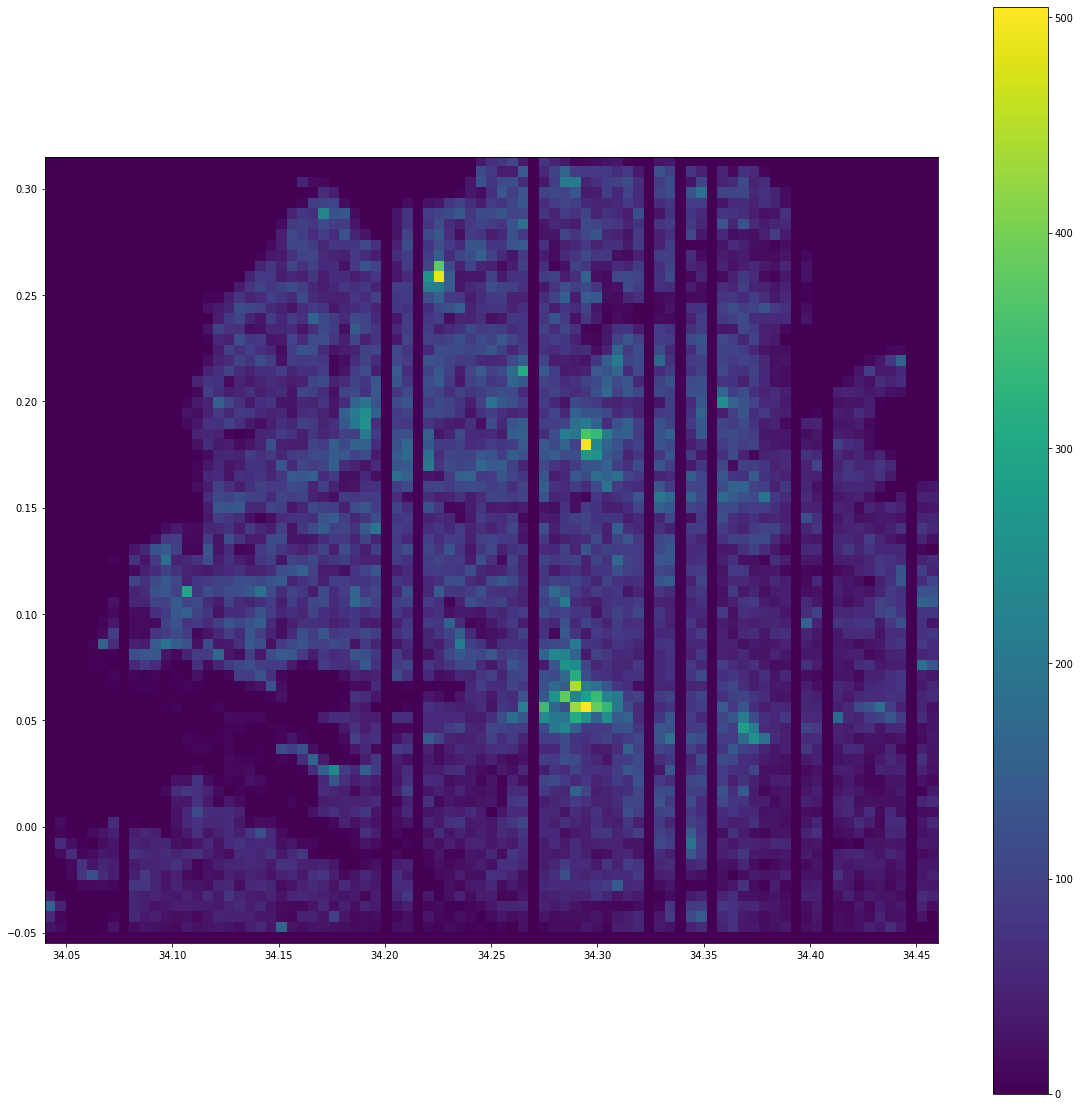

In [12]:
plt.figure(figsize=(20, 20))
plt.imshow(raster, extent=(min_lon, max_lon, min_lat, max_lat))
plt.colorbar()
plt.show()